# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 5)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2021


In [5]:
if year is None:
    year = cur_year

if last_month is None:
    if year == cur_year:
        last_month = 3
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

In [6]:
pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2021-PATH-Monthly-Ridership-Report.pdf'

In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'y1': 121.284, 'x1': 70.016, 'y2': 245.247, 'x2': 568.926},
 {'y1': 261.316, 'x1': 71.546, 'y2': 407.469, 'x2': 569.691},
 {'y1': 482.459, 'x1': 70.781, 'y2': 603.36, 'x2': 568.161},
 {'y1': 620.96, 'x1': 70.781, 'y2': 761.757, 'x2': 569.691}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[121.284, 70.016, 245.247, 568.926],
 [261.316, 71.546, 407.469, 569.691],
 [482.459, 70.781, 603.36, 568.161],
 [620.96, 70.781, 761.757, 569.691]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.


No module named 'jpype'


{1: [                    0        1       2       3       4       5
  0  Christopher Street   26,739     962     854     590     621
  1           9thStreet   26,244     896     952     631     656
  2          14thStreet   57,131   2,098   1,741   1,188   1,314
  3          23rdStreet   41,605   1,674   1,008     629     810
  4          33rdStreet  188,756   7,269   4,981   3,322   4,568
  5     UPTOWN SUBTOTAL  340,475  12,899   9,536   6,360   7,969
  6                 WTC  323,388  13,097   7,009   5,065   7,089
  7   NEW YORK SUBTOTAL  663,863  25,996  16,545  11,425  15,058,
                       0          1       2       3       4       5
  0               Newark    173,103   6,991   3,768   2,678   4,022
  1             Harrison     48,995   2,021   1,013     675   1,074
  2       Journal Square    220,681   8,605   5,434   3,926   5,193
  3         Grove Street    106,308   3,990   3,065   2,068   2,412
  4       Exchange Place     65,705   2,603   1,534   1,111   1,512
  5

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables
Pg 9: 4 tables
Pg 10: 4 tables
Pg 11: 4 tables
Pg 12: 4 tables


12

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

,0,1,2,3,4,5,date
0,Christopher Street,"26,739",962,854,590,621,2021-01-01
1,9thStreet,"26,244",896,952,631,656,2021-01-01
2,14thStreet,"57,131","2,098","1,741","1,188","1,314",2021-01-01
3,23rdStreet,"41,605","1,674","1,008",629,810,2021-01-01
4,33rdStreet,"188,756","7,269","4,981","3,322","4,568",2021-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,"156,639","5,915","3,494","2,936","3,348",2021-12-01
5,Pavonia/ Newport,"187,731","6,757","4,785","4,221","4,905",2021-12-01
6,Hoboken,"274,397","10,267","7,108","5,460","4,258",2021-12-01
7,NEW JERSEY SUBTOTAL,"1,652,027","61,756","38,845","32,701","34,474",2021-12-01


In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

,station,total,avg weekday,avg sat,avg sun,avg holiday,month
0,Christopher Street,26739,962,854,590,621,2021-01-01
1,9thStreet,26244,896,952,631,656,2021-01-01
2,14thStreet,57131,2098,1741,1188,1314,2021-01-01
3,23rdStreet,41605,1674,1008,629,810,2021-01-01
4,33rdStreet,188756,7269,4981,3322,4568,2021-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,156639,5915,3494,2936,3348,2021-12-01
5,Pavonia/ Newport,187731,6757,4785,4221,4905,2021-12-01
6,Hoboken,274397,10267,7108,5460,4258,2021-12-01
7,NEW JERSEY SUBTOTAL,1652027,61756,38845,32701,34474,2021-12-01


In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

,station,avg daily,total weekday,total sat,total sun,total holiday,month
0,Christopher Street,863,18277,4271,2949,1242,2021-01-01
1,9thStreet,847,17020,4759,3154,1311,2021-01-01
2,14thStreet,1843,39860,8703,5941,2627,2021-01-01
3,23rdStreet,1342,31798,5039,3147,1621,2021-01-01
4,33rdStreet,6089,138106,24903,16612,9135,2021-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,5053,124221,13978,11744,6696,2021-12-01
5,Pavonia/ Newport,6056,141897,19139,16885,9810,2021-12-01
6,Hoboken,8852,215610,28434,21838,8515,2021-12-01
7,NEW JERSEY SUBTOTAL,53291,1296896,155382,130801,68948,2021-12-01


In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2021-01-01 Christopher Street         863          962      854      590   
           9thStreet                  847          896      952      631   
           14thStreet                1843         2098     1741     1188   
           23rdStreet                1342         1674     1008      629   
           33rdStreet                6089         7269     4981     3322   
...                                   ...          ...      ...      ...   
2021-12-01 Exchange Place            5053         5915     3494     2936   
           Pavonia/ Newport          6056         6757     4785     4221   
           Hoboken                   8852        10267     7108     5460   
           NEW JERSEY SUBTOTAL      53291        61756    38845    32701   
           MONTHLY TOTAL            97396       112666    71272    61394   

                                avg holiday    total  total weekday  \
month      station                                                    
2021-01-01 Christopher Street           621    26739          18277   
           9thStreet                    656    26244          17020   
           14thStreet                  1314    57131          39860   
           23rdStreet                   810    41605          31798   
           33rdStreet                  4568   188756         138106   
...                                     ...      ...            ...   
2021-12-01 Exchange Place              3348   156639         124221   
           Pavonia/ Newport            4905   187731         141897   
           Hoboken                     4258   274397         215610   
           NEW JERSEY SUBTOTAL        34474  1652027        1296896   
           MONTHLY TOTAL              61310  3019280        2365995   

                                total sat  total sun  total holiday  
month      station                                                   
2021-01-01 Christopher Street        4271       2949           1242  
           9thStreet                 4759       3154           1311  
           14thStreet                8703       5941           2627  
           23rdStreet                5039       3147           1621  
           33rdStreet               24903      16612           9135  
...                                   ...        ...            ...  
2021-12-01 Exchange Place           13978      11744           6696  
           Pavonia/ Newport         19139      16885           9810  
           Hoboken                  28434      21838           8515  
           NEW JERSEY SUBTOTAL     155382     130801          68948  
           MONTHLY TOTAL           285089     245577         122619  

[204 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

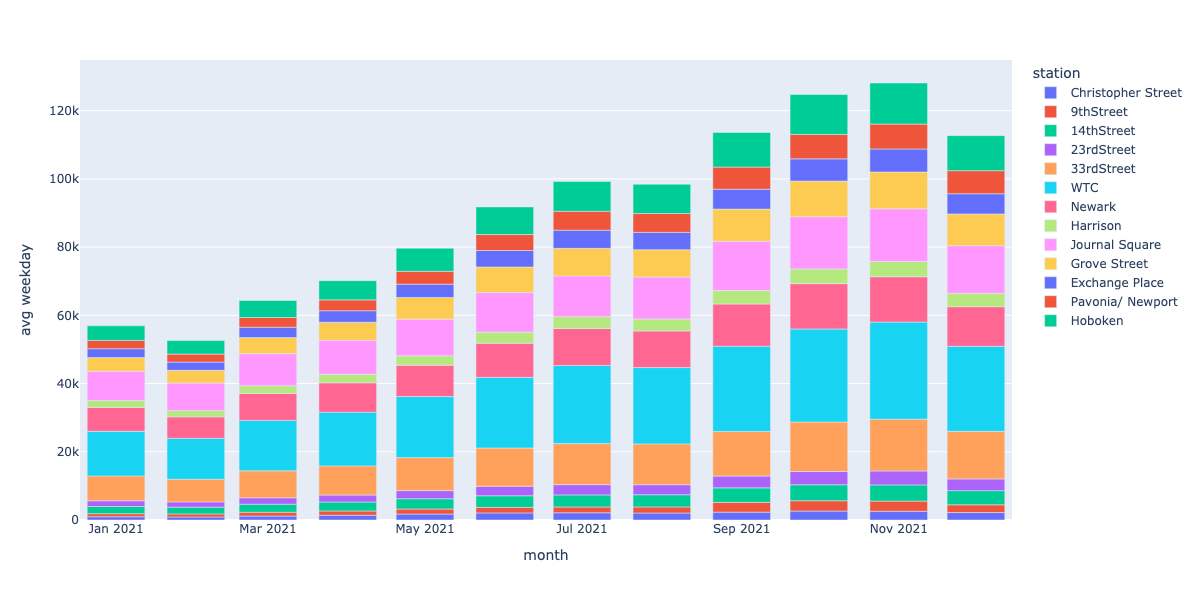

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))